- competition/dataset : [https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data)
- date : 2021/03/29
- original : [https://www.kaggle.com/rhodiumbeng/classifying-multi-label-comments-0-9741-lb](https://www.kaggle.com/rhodiumbeng/classifying-multi-label-comments-0-9741-lb)

## Classifying multi-label comments (0.9741 lb)

**✏ 필사 1회** 

**참고한 커널:**  
- kernel by Jeremy Howard : [NB-SVM strong linear baseline + EDA (0.052 lb)](https://www.kaggle.com/joaomarcosgris/nb-svm-strong-linear-baseline-eda-0-052-lb/comments)
- kernel by Issac : [logistic regression (0.055 lb)](https://www.kaggle.com/ginotesei/logistic-regression-0-055-lb)
- [Solving Multi-Label Classification problems](https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Load training and test data

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

### Examine the data (EDA)

In [3]:
train_df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
66157,b0eaf66af481b733,Football Aid\nI've noticed you did an edit on ...,0,0,0,0,0,0
147382,3b9071fc3e200a10,"""\nWhat do you think I read the entire website...",0,0,0,0,0,0
140467,efb0f567b44bd09b,"""\n\nYou say no transwomen believe this, it ha...",0,0,0,0,0,0
121448,89cc5e1607516bc6,"""==Sockpuppetry case==\n \nYour name has been ...",0,0,0,0,0,0
94462,fc94892dbebf39a6,"97.84.13.145 is right, it's not about whether ...",0,0,0,0,0,0


In [4]:
cols_target = ['obscene', 'insult', 'toxic', 'severe_toxic', 'identity_hate', 'threat']

In [5]:
# check missing values in numeric columns
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


결측값은 없습니다. 평균값은 모두 0.05 이하로 매우 작기 때문에 6개의 범주에서 양의 값으로 라벨링되지 않는 경우가 많습니다. 이로부터 여섯 개의 범주 중 어느 것이라도 라벨링되지 않은 댓글들이 많을 것이라고 예상합니다.

In [6]:
unlabeled_in_all = train_df[(train_df['toxic'] != 1)&(train_df['severe_toxic'] != 1)&(train_df['obscene'] != 1)&(train_df['threat'] != 1)&(train_df['insult'] != 1)&(train_df['identity_hate'] != 1)]
print('Percentage of Unlabeled comments is', len(unlabeled_in_all)/len(train_df)*100)

Percentage of Unlabeled comments is 89.83211235124176


In [7]:
# check for any 'null' comment
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

0

In [8]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [9]:
no_comment = test_df[test_df['comment_text'].isnull()]
no_comment

,id,comment_text


트레이닝 데이터와 테스트 데이터의 모든 행에 댓글이 포함되어 있으므로 null값을 제거할 필요가 없습니다.

In [10]:
# 훈련, 테스트 데이터의 전체 길이와 카테고리별 수 확인
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in test is 153164
Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


앞에서 언급한 대로, 훈련 데이터에 있는 댓글의 대부분은 이러한 범주들 중 하나 이상에 라벨링되지 않았습니다.

In [11]:
# 훈련 데이터의 문자 길이
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))

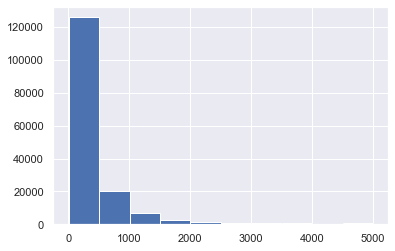

In [12]:
# 텍스트 길이에 대한 히스토그램
sns.set()
train_df['char_length'].hist()
plt.show()

대부분의 텍스트의 길이는 500자 이내이며, 일부는 5000자까지도 있습니다.  

이번에는 타겟 변수들 간의 상관관계를 확인해보겠습니다.

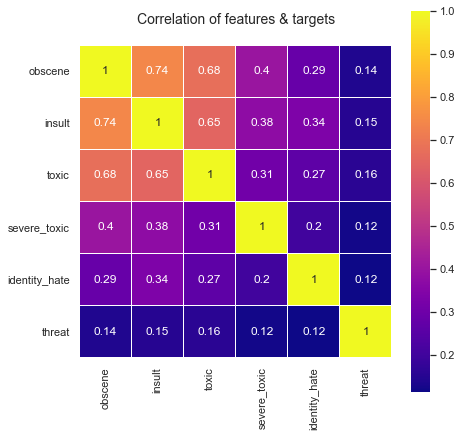

In [13]:
data = train_df[cols_target]

colormap = plt.cm.plasma
plt.figure(figsize=(7, 7))
plt.title('Correlation of features & targets', y=1.05, size=14)
sns.heatmap(data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True,
            cmap=colormap, linecolor='white', annot=True)
plt.show()

일부 라벨간에는 높은 상관관계가 있는 것으로 보입니다. insult와 obscene은 0.74로 가장 높으며, toxic과 obscene, toxic과 insult가 뒤를 잇습니다.  

테스트 데이터 내 댓글의 문자 길이와 분포는 어떨까요?

In [14]:
test_df['char_length'] = test_df['comment_text'].apply(lambda x: len(str(x)))

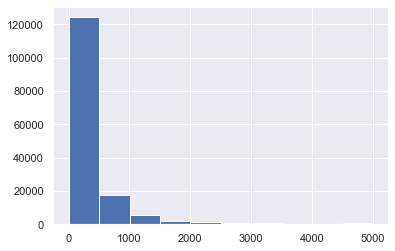

In [15]:
plt.figure()
plt.hist(test_df['char_length'])
plt.show()

### Clean up the comment text

In [16]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [17]:
# comment_text 정제
train_df['comment_text'] = train_df['comment_text'].map(lambda com: clean_text(com))
test_df['comment_text'] = test_df['comment_text'].map(lambda com: clean_text(com))

### Define X from entire train & test data for use in tokenization by Vectorizer

In [18]:
train_df.drop('char_length', axis=1, inplace=True)
X = train_df['comment_text']
test_X = test_df['comment_text']
print(X.shape, test_X.shape)

(159571,) (153164,)


### Vectorize the data

In [19]:
# TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000, stop_words='english')
vect

TfidfVectorizer(max_features=5000, stop_words='english')

In [20]:
# 데이터의 단어 학습, document-term 매트릭스 생성
X_dtm = vect.fit_transform(X)
test_X_dtm = vect.transform(test_X)

### Solving a multi-label classification problem
다중 레이블 분류 문제를 해결하기 위한 한 가지 접근 방법은 별도의 단일 클래스 분류 문제로 바꾸는 것입니다. 이것은 `problem transformation`으로 알려져 있으며, 다음과 같이 세 가지 방법이 있습니다:  
- **Binary Relevance**: 각 라벨을 별도의 단일 분류 문제로 취급하는 가장 간단한 방법. 여기서 가장 중요한 가정은 라벨 간에 상관관계가 없다는 것
- **Classifier Chains**: 이 방법에서 첫 번째 분류기는 입력 X에 대해 훈련. 다음 분류기는 입력 X와 체인 내 모든 이전 분류기들의 예측에 대해 훈련. 이 방법은 이전 타겟 변수 간 상관관계로부터 신호를 끌어오고자 함
- **Label Powerset**: 다중 클래스 라벨들을 본질적으로 모든 고유한 라벨 조합인 다중 클래스 문제로 변환. 우리의 경우, Label Powerset은 실제로 6개의 라벨들을 $2^{6}$ 또는 64 클래스 문제로 변환.

#### Binary Relevance - build a multi-label classifier using Logistic Regression (LB 0.96094)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C=12.0)

In [22]:
# create submission file
submission_binary = pd.read_csv('data/sample_submission.csv')  

for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    logreg.fit(X_dtm, y)
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    test_y_prob = logreg.predict_proba(test_X_dtm)[:, 1]
    submission_binary[label] = test_y_prob

... Processing obscene
Training accuracy is 0.983223768729907
... Processing insult
Training accuracy is 0.9755344016143285
... Processing toxic
Training accuracy is 0.9639470831166064
... Processing severe_toxic
Training accuracy is 0.9920536939669489
... Processing identity_hate
Training accuracy is 0.9939901360522903
... Processing threat
Training accuracy is 0.9981199591404453


In [23]:
submission_binary.to_csv('data/submission_3_submission_binary.csv', index=False)

#### Classifier Chains - build a multi-label classifier using Logistic Regression (LB 0.95697)

In [24]:
submission_chains = pd.read_csv('data/sample_submission.csv')

In [25]:
def add_feature(X, feature_to_add):
    '''
    feature가 추가된 sparse feature matrix (희소 feature 행렬) 리턴
    feature_to_add는 feature 리스트도 입력 가능
    '''
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [27]:
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # X_dtm, y를 사용하여 모델 훈련
    logreg.fit(X_dtm, y)
    # 훈련 정확도 계산
    y_pred_X = logreg.predict(X_dtm)
    print('Training Accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # test_X를 사용하여 예측
    test_y = logreg.predict(test_X_dtm)
    test_y_prob = logreg.predict_proba(test_X_dtm)[:, 1]
    submission_chains[label] = test_y_prob
    # chain current label to X_dtm
    X_dtm = add_feature(X_dtm, y)
    print('Shape of X_dtm is now {}'.format(X_dtm.shape))
    # chain current label predictions to test_X_dtm
    test_X_dtm = add_feature(test_X_dtm, test_y)
    print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))

... Processing obscene
Training Accuracy is 0.983223768729907
Shape of X_dtm is now (159571, 5001)
Shape of test_X_dtm is now (153164, 5001)
... Processing insult
Training Accuracy is 0.9818137380852411
Shape of X_dtm is now (159571, 5002)
Shape of test_X_dtm is now (153164, 5002)
... Processing toxic
Training Accuracy is 0.9675818287784121
Shape of X_dtm is now (159571, 5003)
Shape of test_X_dtm is now (153164, 5003)
... Processing severe_toxic
Training Accuracy is 0.9931065168482995
Shape of X_dtm is now (159571, 5004)
Shape of test_X_dtm is now (153164, 5004)
... Processing identity_hate
Training Accuracy is 0.9955881707829117
Shape of X_dtm is now (159571, 5005)
Shape of test_X_dtm is now (153164, 5005)
... Processing threat
Training Accuracy is 0.9985649021438733
Shape of X_dtm is now (159571, 5006)
Shape of test_X_dtm is now (153164, 5006)


In [28]:
submission_chains.to_csv('data/submission_4_submission_chains.csv', index=False)

#### Create a combined submission (LB 0.96099)

In [29]:
submission_combined = pd.read_csv('data/sample_submission.csv')

In [30]:
for label in cols_target:
    submission_combined[label] = (submission_chains[label] + submission_binary[label])/2

In [31]:
submission_combined.to_csv('data/submission_4_submission_combined.csv', index=False)